# Pilot response model

The pilot response model aims to better capture unmanned aircraft response to advisories (either piloted by human or autonomously). When responding, the pilot executes the advisory for the total length of the period between decisions $T$. In the model, the advisory response in the current time step of $T$ is determined stochastically based on the new advisory via a Bernoulli process. As such, the delay until response follows a geometric distribution, and for some mean time until response $k$, the response probability at each step in the process is $T / (T + k)$.

Specifically,
* the pilot always response to a clear of conflict status "advisory"
* once the pilot responds, it will continue to respond for the duration of the advisory
* the average response delay for initial advisories is $5$ seconds (from ICAO recommended practices for responding to resolution advisories [1])
* when the pilot is not responding, the aircraft follows a white noise model.

[1] International Civil Aviation Organization, “Surveillance, radar and collision avoidance,” in International Standards and Recommended Practices, 4th, vol. IV, annex 10, 2007.

## Load modules

In [1]:
push!(LOAD_PATH, "../dvi")

addprocs(int(CPU_CORES / 2))

using DiscreteValueIteration, JLD, PilotSCAs, PilotSCAViz

mdp = SCA()

SCA(21781,36,[:right20,:right10,:straight,:left10,:left20,:clearOfConflict],RectangleGrid with 21780 points)

## Check size of MDP

In [2]:
function getBytes(x)
   total = 0;
   fieldNames = typeof(x).names;
   if fieldNames == ()
      return sizeof(x);
   else
     for fieldName in fieldNames
        total += getBytes(getfield(x,fieldName));
     end
     return total;
   end
end

println("mdp of type ", typeof(mdp), " takes up ", getBytes(mdp) / 1000.0, " kB")

mdp of type SCA takes up 4.568 kB


## Informal validation of state and action iterators and transition function

In [3]:
nextStateIndices, probs = nextStates(mdp, 1, 15)
println("next state indices:\n", nextStateIndices, "\n")
println("probabilities:\n", probs, "\n")
println("probabilities sum to ", sum(probs))

next state indices:
[1,1,2,21781,21781,1,2,1816,1817,21781,21781,21781,21781,5446,5446,5447,21781,21781,5446,5447,7261,7262,21781,21781,21781,21781,16336,16336,16337,21781,21781,16336,16337,18151,18152,21781,21781,21781,21781,10891,10891,10892,21781,21781,10891,10892,12706,12707,21781,21781,21781,21781]

probabilities:
[0.08333333333333333,0.0203125,0.0005208333333333339,0.020833333333333336,0.020833333333333336,0.0121875,0.00031250000000000033,0.008125000000000002,0.00020833333333333354,0.020833333333333336,0.020833333333333336,0.020833333333333336,0.020833333333333336,0.08333333333333333,0.0203125,0.0005208333333333339,0.020833333333333336,0.020833333333333336,0.0121875,0.00031250000000000033,0.008125000000000002,0.00020833333333333354,0.020833333333333336,0.020833333333333336,0.020833333333333336,0.020833333333333336,0.08333333333333333,0.0203125,0.0005208333333333339,0.020833333333333336,0.020833333333333336,0.0121875,0.00031250000000000033,0.008125000000000002,0.000208333333333333

## Parallel solution

In [4]:
numProcs = int(CPU_CORES / 2)
solver = ParallelSolver(
    numProcs,
    maxIterations = 100,
    tolerance = 1e-2,
    gaussSiedel = true,
    includeV = true,
    includeQ = true,
    includeA = true)

ParallelSolver(2,None[],100,0.01,true,true,true,true)

In [ ]:
policy = solve(solver, mdp, verbose = true)
println("")

In [ ]:
solQ = sharray2array(policy.Q')
save("../../data/pilot-alpha.jld", "solQ", solQ)

## Check against reference solution by visual inspection

In [7]:
d = DoubleUAV()
solQ = load("../../data/pilot-alpha.jld", "solQ")
println("")

### Parallel solver policy plot

Slider{Float64}([Input{Float64}] 180.0,"p",180.0,0.0:90.0:360.0)

Slider{Float64}([Input{Float64}] 15.0,"v0",15.0,10.0:5.0:20.0)

Slider{Float64}([Input{Float64}] 15.0,"v1",15.0,10.0:5.0:20.0)

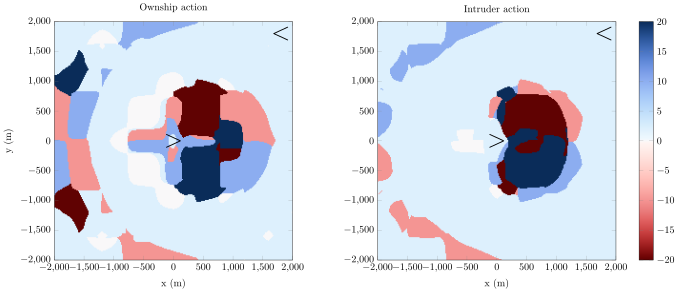

In [8]:
viz_pairwise_policy(d, solQ)